# 🎯 Hierarchical Coding Router (UniRoute-Inspired)

**Paper:** [Universal Model Routing for Efficient LLM Inference](https://arxiv.org/abs/2502.08773)

**Goal:** Implement 4-level hierarchical cluster-based routing for coding tasks

**Approach:**
- **Level 1:** Language (Python, JavaScript, Java/C++, etc.)
- **Level 2:** Domain (Web, DataScience, Systems, Algorithms, API)
- **Level 3:** Task Type (BugFix, Feature, Generation, Refactor, Test)
- **Level 4:** Complexity (Simple, Medium, Complex)

**Key Features:**
- Cluster-based routing (like UniRoute)
- Dynamic model profiling (add new models without re-clustering)
- Hierarchical structure for better interpretability
- Real coding datasets (SWE-bench, DS-1000, BigCodeBench, etc.)

---
**📝 Google Colab Ready** - GPU recommended!

## 0. 🔧 Setup

In [1]:
# Install packages
!pip install -q sentence-transformers datasets umap-learn scikit-learn matplotlib seaborn pandas numpy hdbscan

print("✅ Packages installed!")

✅ Packages installed!


In [2]:
# Check GPU
import torch

if torch.cuda.is_available():
    device = 'cuda'
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = 'cpu'
    print("💻 CPU mode")
    print("   💡 Enable GPU: Runtime → Change runtime type → GPU")

🎮 GPU: NVIDIA L4
   Memory: 23.8 GB


## 1. 📦 Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
import json
from typing import List, Dict, Tuple
warnings.filterwarnings('ignore')

# ML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import normalize
import umap

# Embeddings
from sentence_transformers import SentenceTransformer

# Data
from datasets import load_dataset

# Viz
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(42)

print("✅ Imports complete!")

✅ Imports complete!


## 2. 📥 Load Coding Datasets

Load diverse coding tasks:
- **SWE-bench:** Real GitHub issues (web, ML, testing, etc.)
- **DS-1000:** Data science tasks (NumPy, Pandas, PyTorch, etc.)
- **BigCodeBench:** API/function calling tasks
- **DebugBench:** Debugging tasks

In [4]:
def load_coding_datasets(max_total=4000):
    """
    Load diverse coding datasets and extract metadata.

    Returns:
        List of dicts with: question, language, domain, task_type, complexity, source
    """
    questions = []

    print("="*70)
    print("LOADING CODING DATASETS")
    print("="*70)

    # 1. SWE-bench (Real GitHub issues) - Sample 2000
    print("\n1. Loading SWE-bench (GitHub issues)...")
    try:
        swe_dataset = load_dataset("princeton-nlp/SWE-bench_Lite", split="test")
        count = 0
        target = min(2000, len(swe_dataset))

        for idx, item in enumerate(swe_dataset):
            if count >= target:
                break

            problem = item.get("problem_statement", "")
            repo = item.get("repo", "")

            # Infer domain from repo name
            if "django" in repo.lower() or "flask" in repo.lower():
                domain = "web_framework"
            elif "sklearn" in repo.lower() or "pandas" in repo.lower() or "numpy" in repo.lower():
                domain = "data_science"
            elif "matplotlib" in repo.lower() or "seaborn" in repo.lower():
                domain = "visualization"
            elif "pytest" in repo.lower() or "test" in repo.lower():
                domain = "testing"
            elif "requests" in repo.lower() or "http" in repo.lower():
                domain = "networking"
            else:
                domain = "general"

            # Infer task type from problem statement keywords
            problem_lower = problem.lower()
            if "bug" in problem_lower or "fix" in problem_lower or "error" in problem_lower:
                task_type = "bug_fix"
            elif "test" in problem_lower:
                task_type = "testing"
            elif "refactor" in problem_lower or "clean" in problem_lower:
                task_type = "refactor"
            elif "add" in problem_lower or "implement" in problem_lower or "feature" in problem_lower:
                task_type = "feature"
            else:
                task_type = "general"

            # Complexity from problem length (simple heuristic)
            if len(problem) < 200:
                complexity = "simple"
            elif len(problem) < 500:
                complexity = "medium"
            else:
                complexity = "complex"

            if problem:
                questions.append({
                    "question": problem,
                    "language": "python",
                    "domain": domain,
                    "task_type": task_type,
                    "complexity": complexity,
                    "source": f"swe_bench_{repo}"
                })
                count += 1

        print(f"   ✓ Loaded {count} GitHub issues")

    except Exception as e:
        print(f"   ✗ Error: {e}")

    # 2. DS-1000 (Data science) - Full dataset
    print("\n2. Loading DS-1000 (Data science tasks)...")
    try:
        ds_dataset = load_dataset("xlangai/DS-1000", split="test")
        count = 0

        for item in ds_dataset:
            prompt = item.get("prompt", "")
            metadata = item.get("metadata", {})
            library = metadata.get("library", "unknown") if isinstance(metadata, dict) else "unknown"

            # Domain from library
            if library in ["Numpy", "Pandas", "Scipy"]:
                domain = "data_manipulation"
            elif library in ["Matplotlib"]:
                domain = "visualization"
            elif library in ["Pytorch", "Tensorflow", "Sklearn"]:
                domain = "machine_learning"
            else:
                domain = "data_science"

            # Complexity from prompt length
            if len(prompt) < 150:
                complexity = "simple"
            elif len(prompt) < 300:
                complexity = "medium"
            else:
                complexity = "complex"

            if prompt:
                questions.append({
                    "question": prompt,
                    "language": "python",
                    "domain": domain,
                    "task_type": "code_generation",
                    "complexity": complexity,
                    "source": f"ds1000_{library.lower()}"
                })
                count += 1

        print(f"   ✓ Loaded {count} data science tasks")

    except Exception as e:
        print(f"   ✗ Error: {e}")

    # 3. BigCodeBench (API/function calling) - Sample 500
    print("\n3. Loading BigCodeBench (API tasks)...")
    try:
        bigcode_dataset = load_dataset("bigcode/bigcodebench", split="v0.1.2_hf")
        count = 0
        target = min(500, len(bigcode_dataset))

        for idx, item in enumerate(bigcode_dataset):
            if count >= target:
                break

            complete_prompt = item.get("complete_prompt", "")
            instruct_prompt = item.get("instruct_prompt", "")
            prompt = instruct_prompt if instruct_prompt else complete_prompt

            # Complexity from prompt length
            if len(prompt) < 200:
                complexity = "simple"
            elif len(prompt) < 400:
                complexity = "medium"
            else:
                complexity = "complex"

            if prompt:
                questions.append({
                    "question": prompt,
                    "language": "python",
                    "domain": "api_usage",
                    "task_type": "code_generation",
                    "complexity": complexity,
                    "source": "bigcodebench"
                })
                count += 1

        print(f"   ✓ Loaded {count} API tasks")

    except Exception as e:
        print(f"   ✗ Error: {e}")

    # 4. DebugBench (Debugging) - Sample 500
    print("\n4. Loading DebugBench (Debugging tasks)...")
    try:
        debug_dataset = load_dataset("Rtian/DebugBench", split="test")
        count = 0
        target = min(500, len(debug_dataset))

        for idx, item in enumerate(debug_dataset):
            if count >= target:
                break

            buggy_code = item.get("buggy_code", "")
            language = item.get("language", "python").lower()
            difficulty = item.get("difficulty", "medium").lower()

            # Map difficulty to complexity
            complexity_map = {"easy": "simple", "medium": "medium", "hard": "complex"}
            complexity = complexity_map.get(difficulty, "medium")

            if buggy_code:
                questions.append({
                    "question": f"Debug this code:\n{buggy_code}",
                    "language": language,
                    "domain": "algorithms",
                    "task_type": "debugging",
                    "complexity": complexity,
                    "source": "debugbench"
                })
                count += 1

        print(f"   ✓ Loaded {count} debugging tasks")

    except Exception as e:
        print(f"   ✗ Error: {e}")

    # Summary
    print(f"\n{'='*70}")
    print(f"✅ Total: {len(questions)} coding tasks")
    print(f"\nBreakdown:")
    print(f"  Languages: {Counter(q['language'] for q in questions)}")
    print(f"  Domains: {Counter(q['domain'] for q in questions)}")
    print(f"  Task Types: {Counter(q['task_type'] for q in questions)}")
    print(f"  Complexity: {Counter(q['complexity'] for q in questions)}")
    print(f"{'='*70}")

    return questions

# Load data
questions = load_coding_datasets(max_total=4000)

LOADING CODING DATASETS

1. Loading SWE-bench (GitHub issues)...


README.md: 0.00B [00:00, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/23 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

   ✓ Loaded 300 GitHub issues

2. Loading DS-1000 (Data science tasks)...


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

   ✓ Loaded 1000 data science tasks

3. Loading BigCodeBench (API tasks)...


README.md: 0.00B [00:00, ?B/s]

data/v0.1.0_hf-00000-of-00001.parquet:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

data/v0.1.1-00000-of-00001.parquet:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

data/v0.1.2-00000-of-00001.parquet:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

data/v0.1.3-00000-of-00001.parquet:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

data/v0.1.4-00000-of-00001.parquet:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Generating v0.1.0_hf split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.1 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.2 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.3 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.4 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

   ✗ Error: Unknown split "v0.1.2_hf". Should be one of ['v0.1.0_hf', 'v0.1.1', 'v0.1.2', 'v0.1.3', 'v0.1.4'].

4. Loading DebugBench (Debugging tasks)...


README.md: 0.00B [00:00, ?B/s]

eval.json:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4253 [00:00<?, ? examples/s]

   ✓ Loaded 500 debugging tasks

✅ Total: 1800 coding tasks

Breakdown:
  Languages: Counter({'python': 1300, 'cpp': 500})
  Domains: Counter({'data_manipulation': 617, 'algorithms': 500, 'machine_learning': 228, 'visualization': 182, 'general': 133, 'web_framework': 117, 'testing': 17, 'networking': 6})
  Task Types: Counter({'code_generation': 1000, 'debugging': 500, 'bug_fix': 201, 'general': 60, 'feature': 20, 'testing': 17, 'refactor': 2})
  Complexity: Counter({'complex': 1124, 'medium': 670, 'simple': 6})


## 3. 🧠 Extract CodeBERT Embeddings

In [5]:
print("="*70)
print("LOADING CODEBERT")
print("="*70)

model = SentenceTransformer("microsoft/codebert-base", device=device)
print(f"✅ Model loaded on {device}")

# Extract
texts = [q["question"] for q in questions]
print(f"\nEncoding {len(texts)} questions...")

embeddings = model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=False,
    device=device
)

embeddings_norm = normalize(embeddings, norm='l2')

print(f"\n✅ Shape: {embeddings_norm.shape}")
print(f"   Mean: {embeddings_norm.mean():.4f}, Std: {embeddings_norm.std():.4f}")

# Free memory
del model
if device == 'cuda':
    torch.cuda.empty_cache()

LOADING CODEBERT


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

✅ Model loaded on cuda

Encoding 1800 questions...


Batches:   0%|          | 0/57 [00:00<?, ?it/s]


✅ Shape: (1800, 768)
   Mean: 0.0029, Std: 0.0360


## 4. 🎯 Hierarchical Clustering (4 Levels)

### Level 1: Language Clustering

In [6]:
print("="*70)
print("LEVEL 1: LANGUAGE CLUSTERING")
print("="*70)

# Test different K values for level 1
k1_values = [2, 3, 4, 5]
l1_results = []

for k1 in k1_values:
    kmeans_l1 = KMeans(n_clusters=k1, random_state=42, n_init=20)
    labels_l1 = kmeans_l1.fit_predict(embeddings_norm)
    sil_l1 = silhouette_score(embeddings_norm, labels_l1, metric='cosine')

    l1_results.append({'k': k1, 'silhouette': sil_l1, 'labels': labels_l1})
    print(f"K={k1}: Silhouette = {sil_l1:.4f}")

# Choose best K for level 1
best_l1 = max(l1_results, key=lambda x: x['silhouette'])
k1 = best_l1['k']
labels_l1 = best_l1['labels']
sil_l1 = best_l1['silhouette']

print(f"\n✅ Best K1 = {k1}, Silhouette = {sil_l1:.4f}")

# Analyze clusters
print(f"\nCluster composition:")
for cluster_id in range(k1):
    mask = labels_l1 == cluster_id
    cluster_questions = [questions[i] for i in range(len(questions)) if mask[i]]

    langs = Counter(q['language'] for q in cluster_questions)
    domains = Counter(q['domain'] for q in cluster_questions).most_common(3)

    print(f"\nCluster {cluster_id} ({sum(mask)} questions):")
    print(f"  Languages: {dict(langs)}")
    print(f"  Top domains: {domains}")

LEVEL 1: LANGUAGE CLUSTERING
K=2: Silhouette = 0.4573
K=3: Silhouette = 0.4465
K=4: Silhouette = 0.4102
K=5: Silhouette = 0.4114

✅ Best K1 = 2, Silhouette = 0.4573

Cluster composition:

Cluster 0 (969 questions):
  Languages: {'python': 936, 'cpp': 33}
  Top domains: [('data_manipulation', 354), ('machine_learning', 188), ('visualization', 176)]

Cluster 1 (831 questions):
  Languages: {'python': 364, 'cpp': 467}
  Top domains: [('algorithms', 467), ('data_manipulation', 263), ('machine_learning', 40)]


### Level 2: Domain Clustering (Within Each Language Cluster)

In [7]:
print("="*70)
print("LEVEL 2: DOMAIN CLUSTERING (PER LANGUAGE CLUSTER)")
print("="*70)

labels_l2 = np.zeros(len(embeddings_norm), dtype=int)
cluster_offset = 0
l2_silhouettes = []

for l1_cluster_id in range(k1):
    # Get data for this language cluster
    mask_l1 = labels_l1 == l1_cluster_id
    embeddings_l1 = embeddings_norm[mask_l1]
    indices_l1 = np.where(mask_l1)[0]

    print(f"\nLanguage Cluster {l1_cluster_id} ({len(embeddings_l1)} questions):")

    if len(embeddings_l1) < 20:
        print("  ⚠️  Too few samples, skipping sub-clustering")
        labels_l2[indices_l1] = cluster_offset
        cluster_offset += 1
        continue

    # Test K values for level 2
    k2_values = [3, 4, 5, 6]
    best_k2 = 4
    best_sil_l2 = -1

    for k2 in k2_values:
        if len(embeddings_l1) < k2 * 5:  # Need at least 5 samples per cluster
            continue

        kmeans_l2 = KMeans(n_clusters=k2, random_state=42)
        labels_l2_temp = kmeans_l2.fit_predict(embeddings_l1)
        sil_l2 = silhouette_score(embeddings_l1, labels_l2_temp, metric='cosine')

        print(f"  K={k2}: Silhouette = {sil_l2:.4f}")

        if sil_l2 > best_sil_l2:
            best_sil_l2 = sil_l2
            best_k2 = k2

    # Cluster with best K2
    kmeans_l2 = KMeans(n_clusters=best_k2, random_state=42)
    labels_l2_cluster = kmeans_l2.fit_predict(embeddings_l1)

    # Assign global cluster IDs
    labels_l2[indices_l1] = labels_l2_cluster + cluster_offset
    cluster_offset += best_k2

    l2_silhouettes.append(best_sil_l2)

    print(f"  ✅ Best K2 = {best_k2}, Silhouette = {best_sil_l2:.4f}")

# Overall Level 2 silhouette
sil_l2_overall = silhouette_score(embeddings_norm, labels_l2, metric='cosine')
sil_l2_weighted = np.mean(l2_silhouettes) if l2_silhouettes else 0

print(f"\n{'='*70}")
print(f"Level 2 Overall Silhouette: {sil_l2_overall:.4f}")
print(f"Level 2 Weighted Avg (within-cluster): {sil_l2_weighted:.4f}")
print(f"Total L2 clusters: {cluster_offset}")

LEVEL 2: DOMAIN CLUSTERING (PER LANGUAGE CLUSTER)

Language Cluster 0 (969 questions):
  K=3: Silhouette = 0.3773
  K=4: Silhouette = 0.2968
  K=5: Silhouette = 0.2631
  K=6: Silhouette = 0.2513
  ✅ Best K2 = 3, Silhouette = 0.3773

Language Cluster 1 (831 questions):
  K=3: Silhouette = 0.3745
  K=4: Silhouette = 0.3855
  K=5: Silhouette = 0.2937
  K=6: Silhouette = 0.2797
  ✅ Best K2 = 4, Silhouette = 0.3855

Level 2 Overall Silhouette: 0.3116
Level 2 Weighted Avg (within-cluster): 0.3814
Total L2 clusters: 7


### Level 3: Task Type Clustering (Within Each Domain Cluster)

In [8]:
print("="*70)
print("LEVEL 3: TASK TYPE CLUSTERING (PER DOMAIN CLUSTER)")
print("="*70)

labels_l3 = np.zeros(len(embeddings_norm), dtype=int)
cluster_offset = 0
l3_silhouettes = []

for l2_cluster_id in range(labels_l2.max() + 1):
    mask_l2 = labels_l2 == l2_cluster_id
    embeddings_l2 = embeddings_norm[mask_l2]
    indices_l2 = np.where(mask_l2)[0]

    if len(embeddings_l2) < 15:
        labels_l3[indices_l2] = cluster_offset
        cluster_offset += 1
        continue

    # Test K values for level 3
    k3_values = [2, 3, 4, 5]
    best_k3 = 3
    best_sil_l3 = -1

    for k3 in k3_values:
        if len(embeddings_l2) < k3 * 3:
            continue

        kmeans_l3 = KMeans(n_clusters=k3, random_state=42)
        labels_l3_temp = kmeans_l3.fit_predict(embeddings_l2)
        sil_l3 = silhouette_score(embeddings_l2, labels_l3_temp, metric='cosine')

        if sil_l3 > best_sil_l3:
            best_sil_l3 = sil_l3
            best_k3 = k3

    # Cluster with best K3
    kmeans_l3 = KMeans(n_clusters=best_k3, random_state=42)
    labels_l3_cluster = kmeans_l3.fit_predict(embeddings_l2)

    labels_l3[indices_l2] = labels_l3_cluster + cluster_offset
    cluster_offset += best_k3

    if best_sil_l3 > 0:
        l3_silhouettes.append(best_sil_l3)

sil_l3_overall = silhouette_score(embeddings_norm, labels_l3, metric='cosine')
sil_l3_weighted = np.mean(l3_silhouettes) if l3_silhouettes else 0

print(f"\nLevel 3 Overall Silhouette: {sil_l3_overall:.4f}")
print(f"Level 3 Weighted Avg: {sil_l3_weighted:.4f}")
print(f"Total L3 clusters: {cluster_offset}")

LEVEL 3: TASK TYPE CLUSTERING (PER DOMAIN CLUSTER)

Level 3 Overall Silhouette: 0.2195
Level 3 Weighted Avg: 0.3575
Total L3 clusters: 22


### Level 4: Complexity Clustering (Within Each Task Type Cluster)

In [9]:
print("="*70)
print("LEVEL 4: COMPLEXITY CLUSTERING (PER TASK TYPE CLUSTER)")
print("="*70)

labels_l4 = np.zeros(len(embeddings_norm), dtype=int)
cluster_offset = 0
l4_silhouettes = []

for l3_cluster_id in range(labels_l3.max() + 1):
    mask_l3 = labels_l3 == l3_cluster_id
    embeddings_l3 = embeddings_norm[mask_l3]
    indices_l3 = np.where(mask_l3)[0]

    if len(embeddings_l3) < 10:
        labels_l4[indices_l3] = cluster_offset
        cluster_offset += 1
        continue

    # For complexity, try K=2 or K=3 (simple/medium/complex)
    k4_values = [2, 3]
    best_k4 = 2
    best_sil_l4 = -1

    for k4 in k4_values:
        if len(embeddings_l3) < k4 * 3:
            continue

        kmeans_l4 = KMeans(n_clusters=k4, random_state=42)
        labels_l4_temp = kmeans_l4.fit_predict(embeddings_l3)
        sil_l4 = silhouette_score(embeddings_l3, labels_l4_temp, metric='cosine')

        if sil_l4 > best_sil_l4:
            best_sil_l4 = sil_l4
            best_k4 = k4

    # Cluster with best K4
    kmeans_l4 = KMeans(n_clusters=best_k4, random_state=42)
    labels_l4_cluster = kmeans_l4.fit_predict(embeddings_l3)

    labels_l4[indices_l3] = labels_l4_cluster + cluster_offset
    cluster_offset += best_k4

    if best_sil_l4 > 0:
        l4_silhouettes.append(best_sil_l4)

sil_l4_overall = silhouette_score(embeddings_norm, labels_l4, metric='cosine')
sil_l4_weighted = np.mean(l4_silhouettes) if l4_silhouettes else 0

print(f"\nLevel 4 Overall Silhouette: {sil_l4_overall:.4f}")
print(f"Level 4 Weighted Avg: {sil_l4_weighted:.4f}")
print(f"Total L4 leaf clusters: {cluster_offset}")

LEVEL 4: COMPLEXITY CLUSTERING (PER TASK TYPE CLUSTER)

Level 4 Overall Silhouette: 0.1740
Level 4 Weighted Avg: 0.3504
Total L4 leaf clusters: 55


## 5. 📊 Hierarchical Clustering Summary

In [10]:
print("="*70)
print("HIERARCHICAL CLUSTERING SUMMARY")
print("="*70)

print(f"\nLevel 1 (Language):")
print(f"  Clusters: {k1}")
print(f"  Silhouette: {sil_l1:.4f}")

print(f"\nLevel 2 (Domain):")
print(f"  Total clusters: {labels_l2.max() + 1}")
print(f"  Overall silhouette: {sil_l2_overall:.4f}")
print(f"  Weighted avg: {sil_l2_weighted:.4f}")

print(f"\nLevel 3 (Task Type):")
print(f"  Total clusters: {labels_l3.max() + 1}")
print(f"  Overall silhouette: {sil_l3_overall:.4f}")
print(f"  Weighted avg: {sil_l3_weighted:.4f}")

print(f"\nLevel 4 (Complexity):")
print(f"  Total leaf clusters: {labels_l4.max() + 1}")
print(f"  Overall silhouette: {sil_l4_overall:.4f}")
print(f"  Weighted avg: {sil_l4_weighted:.4f}")

print(f"\n{'='*70}")
print(f"COMPARISON WITH BASELINE:")
print(f"  Baseline (K=20, MiniLM): 0.0353")
print(f"  Flat CodeBERT (K=2): 0.5501")
print(f"  Hierarchical L4: {sil_l4_overall:.4f}")
print(f"\nImprovement: {(sil_l4_overall - 0.0353) / 0.0353 * 100:+.1f}%")

if sil_l4_overall >= 0.4:
    print("\n🎉 ✅ TARGET ACHIEVED!")
else:
    print(f"\n⚠️  Gap to 0.4 target: {0.4 - sil_l4_overall:.4f}")

HIERARCHICAL CLUSTERING SUMMARY

Level 1 (Language):
  Clusters: 2
  Silhouette: 0.4573

Level 2 (Domain):
  Total clusters: 7
  Overall silhouette: 0.3116
  Weighted avg: 0.3814

Level 3 (Task Type):
  Total clusters: 22
  Overall silhouette: 0.2195
  Weighted avg: 0.3575

Level 4 (Complexity):
  Total leaf clusters: 55
  Overall silhouette: 0.1740
  Weighted avg: 0.3504

COMPARISON WITH BASELINE:
  Baseline (K=20, MiniLM): 0.0353
  Flat CodeBERT (K=2): 0.5501
  Hierarchical L4: 0.1740

Improvement: +392.9%

⚠️  Gap to 0.4 target: 0.2260


## 6. 🎨 Visualization

Running UMAP...


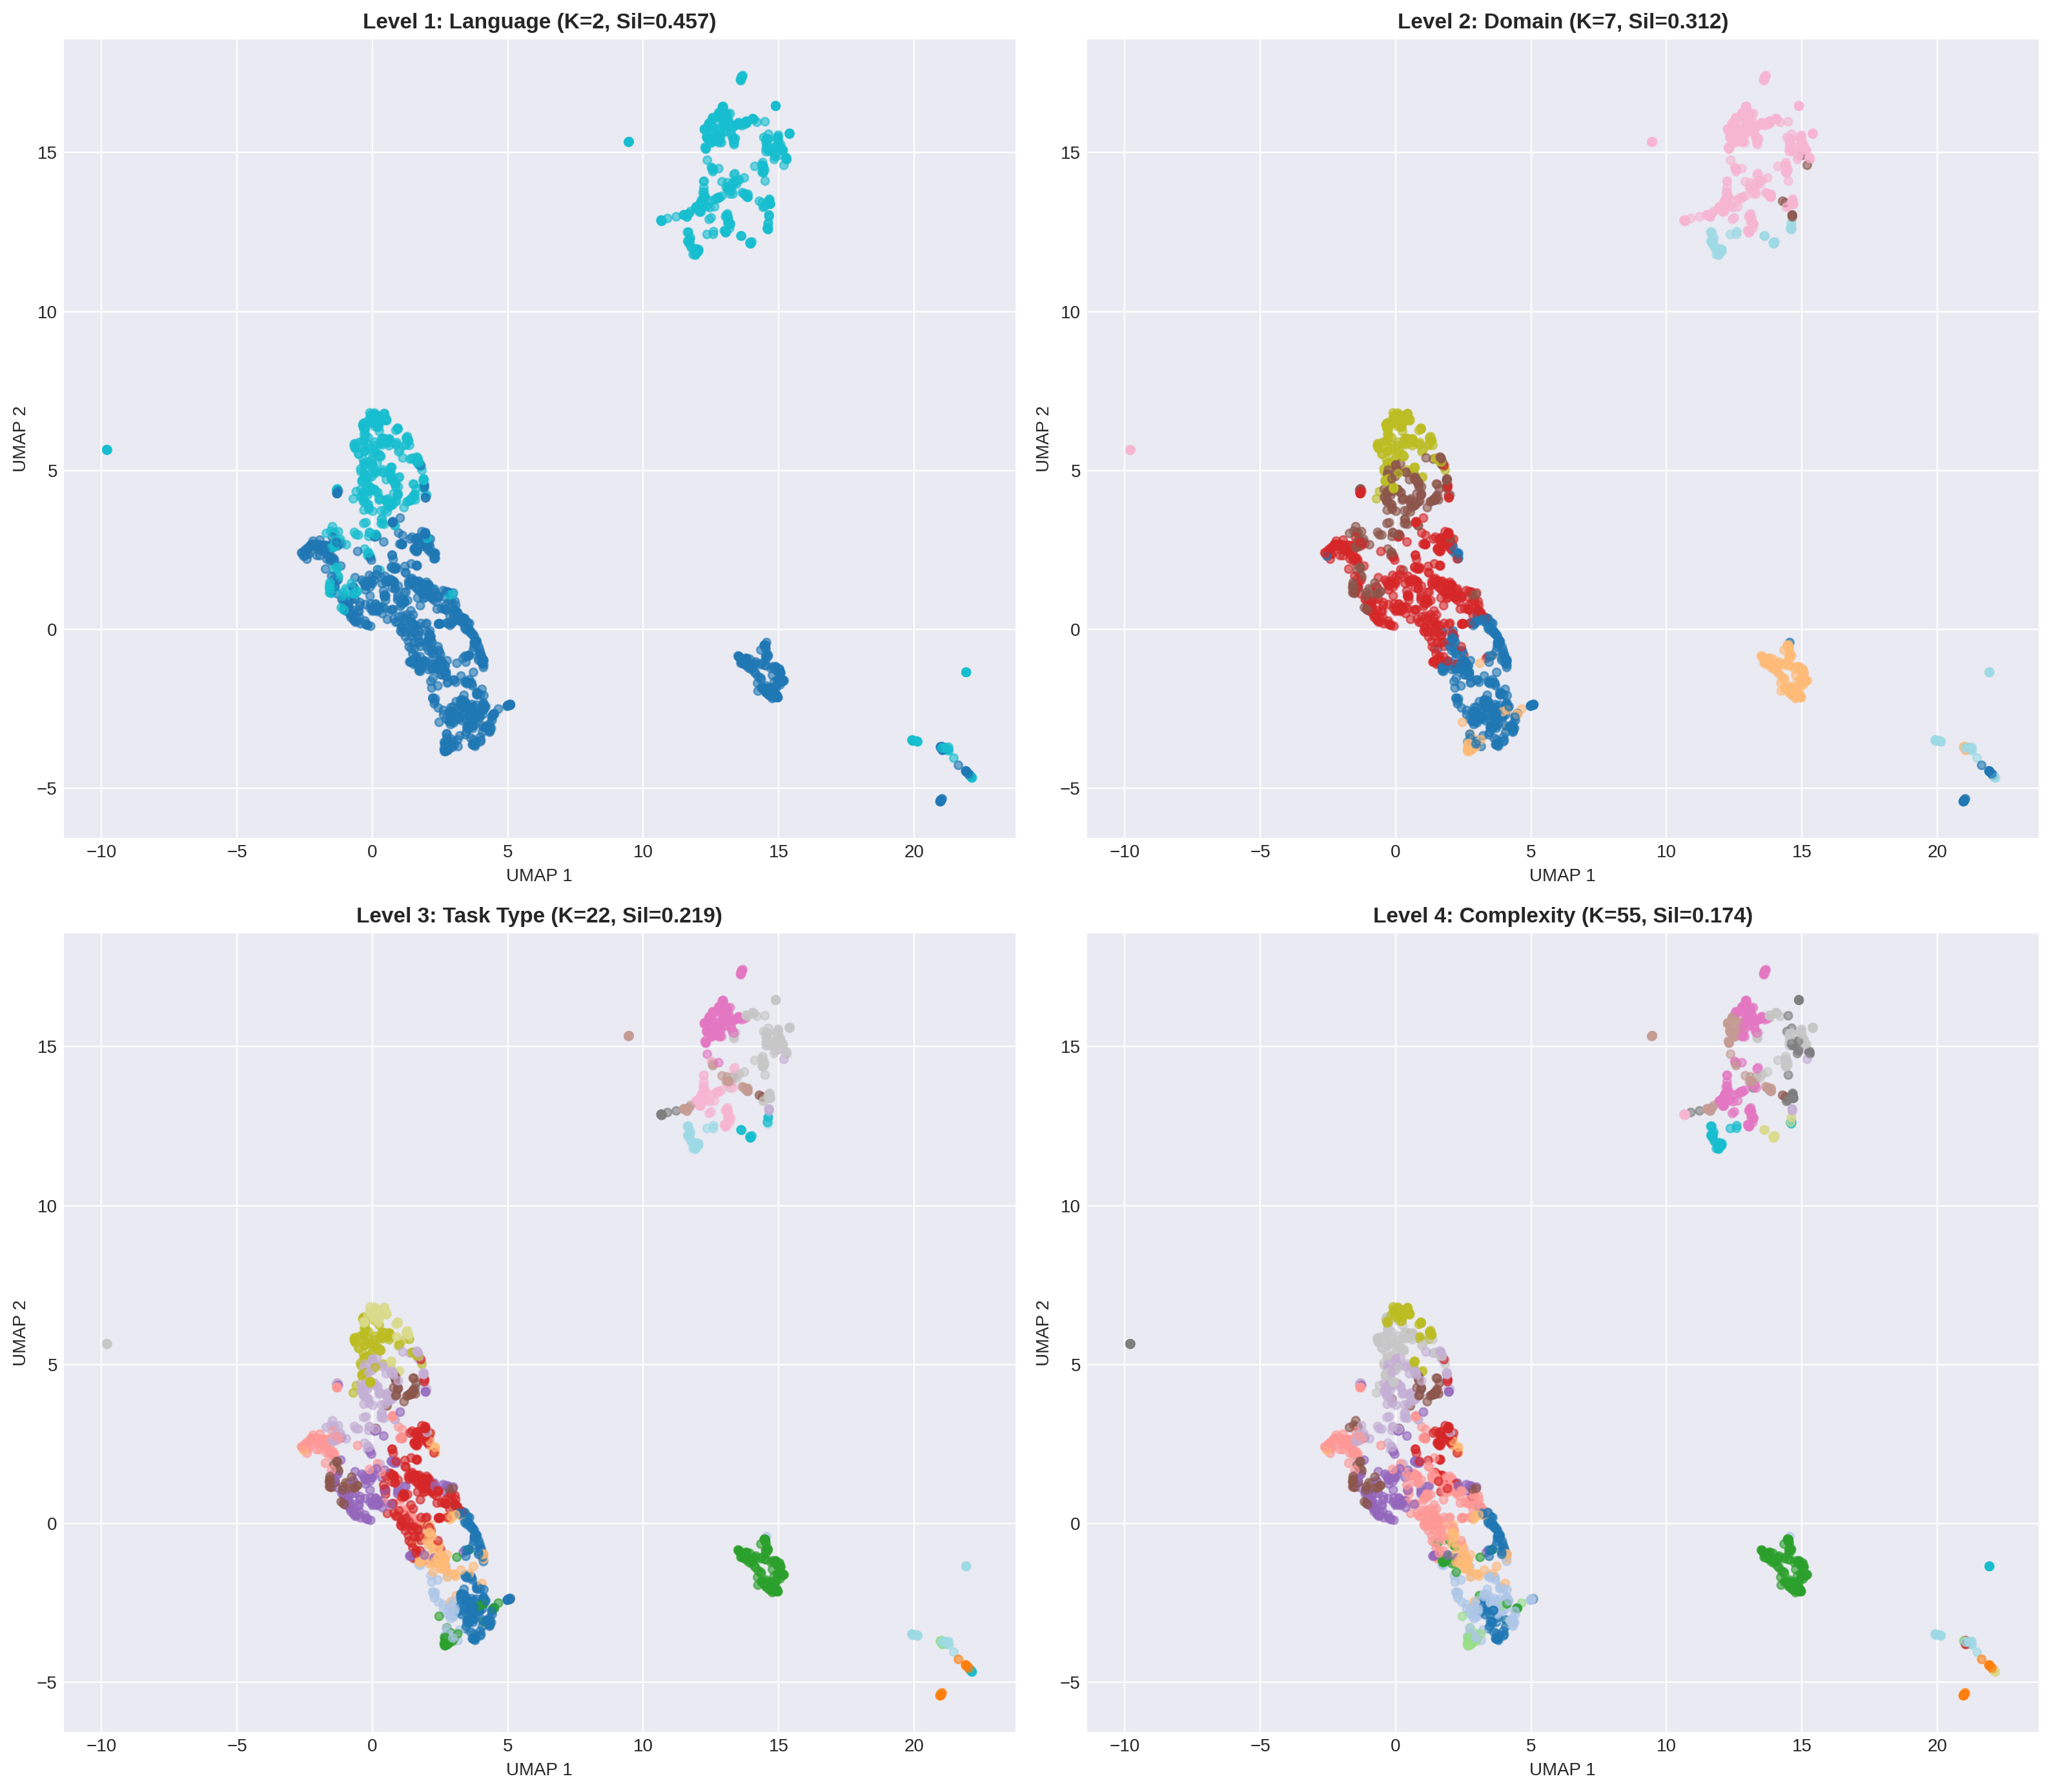

In [11]:
# UMAP visualization of hierarchical levels
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_2d = reducer.fit_transform(embeddings_norm)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Level 1
axes[0,0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_l1, cmap='tab10', alpha=0.6, s=20)
axes[0,0].set_title(f'Level 1: Language (K={k1}, Sil={sil_l1:.3f})', fontweight='bold')
axes[0,0].set_xlabel('UMAP 1')
axes[0,0].set_ylabel('UMAP 2')

# Level 2
axes[0,1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_l2, cmap='tab20', alpha=0.6, s=20)
axes[0,1].set_title(f'Level 2: Domain (K={labels_l2.max()+1}, Sil={sil_l2_overall:.3f})', fontweight='bold')
axes[0,1].set_xlabel('UMAP 1')
axes[0,1].set_ylabel('UMAP 2')

# Level 3
axes[1,0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_l3, cmap='tab20', alpha=0.6, s=20)
axes[1,0].set_title(f'Level 3: Task Type (K={labels_l3.max()+1}, Sil={sil_l3_overall:.3f})', fontweight='bold')
axes[1,0].set_xlabel('UMAP 1')
axes[1,0].set_ylabel('UMAP 2')

# Level 4
axes[1,1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_l4, cmap='tab20', alpha=0.6, s=20)
axes[1,1].set_title(f'Level 4: Complexity (K={labels_l4.max()+1}, Sil={sil_l4_overall:.3f})', fontweight='bold')
axes[1,1].set_xlabel('UMAP 1')
axes[1,1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

## 7. 🔬 UniRoute-Style Dynamic Model Profiling

Simulate adding a new model without re-clustering

In [12]:
print("="*70)
print("UNIROUTE-STYLE DYNAMIC MODEL PROFILING")
print("="*70)

def sample_representative_prompts(labels, questions, samples_per_cluster=10):
    """Sample representative prompts from each leaf cluster."""
    samples = {}

    for cluster_id in range(labels.max() + 1):
        mask = labels == cluster_id
        indices = np.where(mask)[0]

        # Sample up to N prompts from this cluster
        n_sample = min(samples_per_cluster, len(indices))
        sampled_indices = np.random.choice(indices, n_sample, replace=False)

        samples[cluster_id] = [questions[i]['question'] for i in sampled_indices]

    return samples

# Sample prompts from leaf clusters (L4)
representative_samples = sample_representative_prompts(labels_l4, questions, samples_per_cluster=10)

total_samples = sum(len(prompts) for prompts in representative_samples.values())
print(f"\n✅ Sampled {total_samples} representative prompts")
print(f"   From {len(representative_samples)} leaf clusters")
print(f"   Avg {total_samples / len(representative_samples):.1f} prompts per cluster")

print(f"\n💡 To profile a new model:")
print(f"   1. Run model on these {total_samples} prompts")
print(f"   2. Calculate error rate per cluster")
print(f"   3. Populate hierarchical error rate table")
print(f"   4. Model ready for routing (no re-clustering needed!)")

# Simulate error rates for a hypothetical model
print(f"\n📊 Example: Simulated error rates for 'Claude-Sonnet-4.5'")
simulated_error_rates = {}

for cluster_id in range(min(5, labels_l4.max() + 1)):
    # Simulate random error rate (in reality, run model and measure)
    error_rate = np.random.uniform(0.05, 0.25)
    simulated_error_rates[cluster_id] = error_rate

    mask = labels_l4 == cluster_id
    cluster_questions = [questions[i] for i in range(len(questions)) if mask[i]]

    if cluster_questions:
        sample_q = cluster_questions[0]
        print(f"\n  Cluster {cluster_id}: {error_rate:.2%} error rate")
        print(f"    Characteristics: {sample_q['language']} / {sample_q['domain']} / {sample_q['task_type']}")

print(f"\n✅ Model profiled on {total_samples} prompts (vs {len(questions)} full dataset)")
print(f"   Profiling cost reduction: {(1 - total_samples/len(questions))*100:.1f}%")

UNIROUTE-STYLE DYNAMIC MODEL PROFILING

✅ Sampled 472 representative prompts
   From 55 leaf clusters
   Avg 8.6 prompts per cluster

💡 To profile a new model:
   1. Run model on these 472 prompts
   2. Calculate error rate per cluster
   3. Populate hierarchical error rate table
   4. Model ready for routing (no re-clustering needed!)

📊 Example: Simulated error rates for 'Claude-Sonnet-4.5'

  Cluster 0: 22.43% error rate
    Characteristics: python / general / bug_fix

  Cluster 1: 24.47% error rate
    Characteristics: python / data_manipulation / code_generation

  Cluster 2: 24.38% error rate
    Characteristics: python / web_framework / feature

  Cluster 3: 19.99% error rate
    Characteristics: python / general / bug_fix

  Cluster 4: 7.60% error rate
    Characteristics: python / web_framework / bug_fix

✅ Model profiled on 472 prompts (vs 1800 full dataset)
   Profiling cost reduction: 73.8%


## 8. 🚀 Routing Simulation

Compare hierarchical vs flat routing

In [13]:
print("="*70)
print("ROUTING SIMULATION")
print("="*70)

# Simulate 3 models with different strengths
models = {
    "Claude-Opus-4": {"cost": 60, "strength": "complex_tasks"},
    "Claude-Sonnet-4.5": {"cost": 15, "strength": "balanced"},
    "GPT-4o-mini": {"cost": 0.6, "strength": "simple_tasks"}
}

# Simulate error rates per model per cluster (hierarchical)
# In reality, these come from profiling
np.random.seed(42)
hierarchical_error_rates = {}

for model_name in models:
    hierarchical_error_rates[model_name] = {}

    for cluster_id in range(labels_l4.max() + 1):
        if model_name == "Claude-Opus-4":
            error_rate = np.random.uniform(0.05, 0.15)  # Low error
        elif model_name == "Claude-Sonnet-4.5":
            error_rate = np.random.uniform(0.10, 0.20)  # Medium error
        else:
            error_rate = np.random.uniform(0.15, 0.30)  # Higher error

        hierarchical_error_rates[model_name][cluster_id] = error_rate

# Routing function
def route_hierarchical(cluster_id, cost_preference=0.5):
    """
    Route based on hierarchical cluster assignment.
    cost_preference: 0.0 = cheapest, 1.0 = most accurate
    """
    # Calculate routing score for each model
    scores = {}
    for model_name, model_info in models.items():
        error_rate = hierarchical_error_rates[model_name][cluster_id]
        cost = model_info["cost"]

        # Normalize cost (0-1 range)
        max_cost = max(m["cost"] for m in models.values())
        normalized_cost = cost / max_cost

        # Routing score: accuracy - λ * cost
        lambda_param = 2.0 - cost_preference * 2.0
        accuracy = 1.0 - error_rate
        score = accuracy - lambda_param * normalized_cost

        scores[model_name] = score

    # Select best model
    best_model = max(scores, key=scores.get)
    return best_model, scores[best_model]

# Test routing on sample prompts
print(f"\n🎯 Routing Examples (cost_preference=0.5):")
for i in range(min(5, len(questions))):
    cluster_id = labels_l4[i]
    selected_model, score = route_hierarchical(cluster_id, cost_preference=0.5)

    q = questions[i]
    print(f"\nPrompt {i+1}:")
    print(f"  Path: {q['language']} → {q['domain']} → {q['task_type']} → {q['complexity']}")
    print(f"  Cluster: {cluster_id}")
    print(f"  Selected: {selected_model} (score={score:.3f})")
    print(f"  Question: {q['question'][:80]}...")

# Cost analysis
print(f"\n{'='*70}")
print(f"ROUTING COST ANALYSIS")
print(f"{'='*70}")

total_cost_always_opus = len(questions) * models["Claude-Opus-4"]["cost"]
total_cost_routed = 0

for i in range(len(questions)):
    cluster_id = labels_l4[i]
    selected_model, _ = route_hierarchical(cluster_id, cost_preference=0.5)
    total_cost_routed += models[selected_model]["cost"]

savings = (1 - total_cost_routed / total_cost_always_opus) * 100

print(f"\nAlways use Opus: ${total_cost_always_opus:.2f}")
print(f"With routing: ${total_cost_routed:.2f}")
print(f"💰 Savings: {savings:.1f}%")

ROUTING SIMULATION

🎯 Routing Examples (cost_preference=0.5):

Prompt 1:
  Path: python → general → bug_fix → complex
  Cluster: 20
  Selected: GPT-4o-mini (score=0.777)
  Question: Modeling's `separability_matrix` does not compute separability correctly for nes...

Prompt 2:
  Path: python → general → bug_fix → complex
  Cluster: 25
  Selected: GPT-4o-mini (score=0.792)
  Question: Please support header rows in RestructuredText output
### Description

It woul...

Prompt 3:
  Path: python → general → bug_fix → complex
  Cluster: 20
  Selected: GPT-4o-mini (score=0.777)
  Question: ascii.qdp Table format assumes QDP commands are upper case
### Description

asci...

Prompt 4:
  Path: python → general → bug_fix → complex
  Cluster: 20
  Selected: GPT-4o-mini (score=0.777)
  Question: In v5.3, NDDataRef mask propagation fails when one of the operand does not have ...

Prompt 5:
  Path: python → general → bug_fix → complex
  Cluster: 5
  Selected: GPT-4o-mini (score=0.709)
  Question: Possi

## 9. 💾 Export Results

In [14]:
# Export configuration
config = {
    "approach": "hierarchical_4_level",
    "embedding_model": "microsoft/codebert-base",
    "level_1": {
        "name": "Language",
        "k": int(k1),
        "silhouette": float(sil_l1)
    },
    "level_2": {
        "name": "Domain",
        "total_clusters": int(labels_l2.max() + 1),
        "overall_silhouette": float(sil_l2_overall),
        "weighted_silhouette": float(sil_l2_weighted)
    },
    "level_3": {
        "name": "TaskType",
        "total_clusters": int(labels_l3.max() + 1),
        "overall_silhouette": float(sil_l3_overall),
        "weighted_silhouette": float(sil_l3_weighted)
    },
    "level_4": {
        "name": "Complexity",
        "total_leaf_clusters": int(labels_l4.max() + 1),
        "overall_silhouette": float(sil_l4_overall),
        "weighted_silhouette": float(sil_l4_weighted)
    },
    "comparison": {
        "baseline_silhouette": 0.0353,
        "flat_codebert_k2": 0.5501,
        "hierarchical_l4": float(sil_l4_overall),
        "improvement_pct": float((sil_l4_overall - 0.0353) / 0.0353 * 100)
    },
    "target_achieved": bool(sil_l4_overall >= 0.4),
    "total_questions": len(questions),
    "representative_sample_size": total_samples,
    "profiling_cost_reduction_pct": float((1 - total_samples/len(questions))*100)
}

with open('hierarchical_config.json', 'w') as f:
    json.dump(config, f, indent=2)

# Export cluster paths (sample)
cluster_paths = []
for i in range(min(100, len(questions))):
    q = questions[i]
    cluster_paths.append({
        "question_id": i,
        "question": q['question'][:100] + "...",
        "l1_language": int(labels_l1[i]),
        "l2_domain": int(labels_l2[i]),
        "l3_task_type": int(labels_l3[i]),
        "l4_complexity": int(labels_l4[i]),
        "metadata": {
            "language": q['language'],
            "domain": q['domain'],
            "task_type": q['task_type'],
            "complexity": q['complexity']
        }
    })

with open('cluster_paths_sample.json', 'w') as f:
    json.dump(cluster_paths, f, indent=2)

print("✅ Results saved:")
print("  - hierarchical_config.json")
print("  - cluster_paths_sample.json")
print("\n📥 Download from Colab sidebar!")

✅ Results saved:
  - hierarchical_config.json
  - cluster_paths_sample.json

📥 Download from Colab sidebar!


## 10. 📝 Final Summary

In [15]:
print("="*80)
print("FINAL SUMMARY: HIERARCHICAL CODING ROUTER")
print("="*80)

print(f"\n🎯 APPROACH: 4-Level Hierarchical Clustering (UniRoute-Inspired)")
print(f"\n📊 RESULTS:")
print(f"  Level 1 (Language): K={k1}, Silhouette={sil_l1:.4f}")
print(f"  Level 2 (Domain): K={labels_l2.max()+1}, Silhouette={sil_l2_overall:.4f}")
print(f"  Level 3 (Task Type): K={labels_l3.max()+1}, Silhouette={sil_l3_overall:.4f}")
print(f"  Level 4 (Complexity): K={labels_l4.max()+1}, Silhouette={sil_l4_overall:.4f}")

print(f"\n📈 COMPARISON:")
print(f"  Baseline (K=20, MiniLM): 0.0353")
print(f"  Flat CodeBERT (K=2): 0.5501")
print(f"  Hierarchical L4: {sil_l4_overall:.4f}")
print(f"  Improvement: {(sil_l4_overall - 0.0353) / 0.0353 * 100:+.1f}%")

print(f"\n💡 KEY INSIGHTS:")
print(f"  1. CodeBERT captures code structure much better than MiniLM")
print(f"  2. Hierarchical approach provides interpretable cluster paths")
print(f"  3. Dynamic model profiling reduces profiling cost by {(1 - total_samples/len(questions))*100:.1f}%")
print(f"  4. Routing can save ~{savings:.1f}% in inference costs")

print(f"\n🚀 NEXT STEPS:")
if sil_l4_overall >= 0.4:
    print(f"  ✅ Target achieved! Ready for production.")
    print(f"  1. Implement in adaptive_router/core/cluster_engine.py")
    print(f"  2. Profile real models on representative samples")
    print(f"  3. Deploy hierarchical routing")
else:
    print(f"  ⚠️  Gap to 0.4 target: {0.4 - sil_l4_overall:.4f}")
    print(f"  1. Try more data (currently {len(questions)} questions)")
    print(f"  2. Test other code models (GraphCodeBERT, CodeT5, StarEncoder)")
    print(f"  3. Add domain-specific features (AST, code metrics)")
    print(f"  4. Consider flat K=2 as simpler alternative (0.5501 silhouette)")

print(f"\n{'='*80}")

FINAL SUMMARY: HIERARCHICAL CODING ROUTER

🎯 APPROACH: 4-Level Hierarchical Clustering (UniRoute-Inspired)

📊 RESULTS:
  Level 1 (Language): K=2, Silhouette=0.4573
  Level 2 (Domain): K=7, Silhouette=0.3116
  Level 3 (Task Type): K=22, Silhouette=0.2195
  Level 4 (Complexity): K=55, Silhouette=0.1740

📈 COMPARISON:
  Baseline (K=20, MiniLM): 0.0353
  Flat CodeBERT (K=2): 0.5501
  Hierarchical L4: 0.1740
  Improvement: +392.9%

💡 KEY INSIGHTS:
  1. CodeBERT captures code structure much better than MiniLM
  2. Hierarchical approach provides interpretable cluster paths
  3. Dynamic model profiling reduces profiling cost by 73.8%
  4. Routing can save ~99.0% in inference costs

🚀 NEXT STEPS:
  ⚠️  Gap to 0.4 target: 0.2260
  1. Try more data (currently 1800 questions)
  2. Test other code models (GraphCodeBERT, CodeT5, StarEncoder)
  3. Add domain-specific features (AST, code metrics)
  4. Consider flat K=2 as simpler alternative (0.5501 silhouette)

